# 2.6 SubGraph: LangGraph Agent를 Node로 활용하는 방법

- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)논문을 구현합니다
- LangGraph 공식문서의 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요

![adaptive-rag](https://i.imgur.com/tbICSxY.png)

In [15]:
from dotenv import load_dotenv

load_dotenv()

True

In [16]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [17]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}

In [18]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LangChain 허브에서 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")
# OpenAI의 GPT-4o 모델을 사용합니다
generate_llm = ChatOpenAI(model="gpt-4o")

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.

    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    # state에서 문맥과 질문을 추출합니다
    context = state['context']
    query = state['query']
    
    # 프롬프트와 모델, 출력 파서를 연결하여 체인을 생성합니다
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': response}

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- 간단한 질문에 답변을 하는 경우 작은 모델을 활용해서 비용을 저감하고, 답변 생성 속도를 향상시킬 수 있습니다

In [19]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# OpenAI의 GPT-4o-mini 모델을 사용합니다
basic_llm = ChatOpenAI(model="gpt-4o-mini")

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    # state에서 질문을 추출합니다
    query = state['query']
    
    # 기본 LLM 체인을 생성합니다
    basic_llm_chain = basic_llm | StrOutputParser()
    
    # 체인을 사용하여 답변을 생성합니다
    llm_response = basic_llm_chain.invoke(query)
    
    # 생성된 답변을 'answer'로 반환합니다
    return {'answer': llm_response}

- 사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동합니다
    - 사용자의 질문에 관한 내용이 vector store에 있는 경우 `income_tax_agent` 노드로 이동합니다
    - 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동합니다
    - 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동합니다

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    사용자의 질문에 기반하여 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        Literal['vector_store', 'llm', 'web_search']: 질문을 처리하기 위한 적절한 경로를 나타내는 문자열.
    """
    # state에서 질문을 추출합니다
    query = state['query']
    
    # 프롬프트와 구조화된 라우터 LLM을 연결하여 체인을 생성합니다
    router_chain = router_prompt | structured_router_llm 
    
    # 체인을 사용하여 경로를 결정합니다
    route = router_chain.invoke({'query': query})

    # 결정된 경로의 타겟을 반환합니다
    return route.target

- `node`를 추가하고 `edge`로 연결합니다

In [21]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/sangjinsu/projects/inflearn-langgraph-lecture/.venv/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [22]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START, 
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [23]:
graph = graph_builder.compile()

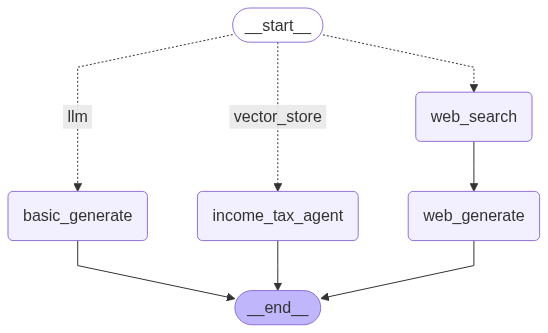

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
initial_state = {'query': '대한민국의 수도는 어디인가요?'}
graph.invoke(initial_state)

{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [26]:
initial_state = {'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='c3d95c37-2b30-4784-bfc1-51691e476b39', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2

In [27]:
initial_state = {'query': '역삼 맛집을 추천해주세요'}
graph.invoke(initial_state)

{'query': '역삼 맛집을 추천해주세요',
 'context': [{'title': '역삼역 주변 맛집 리스트 - pangpang - 티스토리',
   'url': 'https://sam-repository.tistory.com/11',
   'content': "키워드:#술 #플래터 #맥주 #하이볼 #논알콜도있어요 #와인 #단체회식\n\n도로명주소:서울 강남구 테헤란로33길 18 1층\n\n맛있게 먹은 사람:76.19%(432 / 567)\n\n한 줄 평가:눈이 즐거워지는 대용량 플래터 와 인테리어가 인상적인 맥주집!\n\n맥주, 하이볼, 와인, 논알콜 다양한 종류가 있어서 주종 상관 없이 취향껏 즐길 수 있어요. 무엇보다 여러 명이서 가서 플래터를 하나 시키면 맛있고 양이 많아서 남녀노소 누구나 즐길 수 있는 술집입니다. 뿐만 아니라 인테리어, 화장실도 깔끔해서 역삼역 회식 장소로 강추!\n\n10. 신동궁감자탕 역삼직영점\n--------------------\n\nImage 12\n\n역삼역 맛집 10. 신동궁감자탕 역삼직영점\n\n키워드:#한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수\n\n도로명주소: 서울 강남구 테헤란로10길 21 1층\n\n맛있게 먹은 사람: 73.77%(987 / 1338) [...] 한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!\n\n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이 를 도전해보시는 건 어떨까요? 꽤 매운 편 이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n  \n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 읽